[*********************100%***********************]  1 of 1 completed


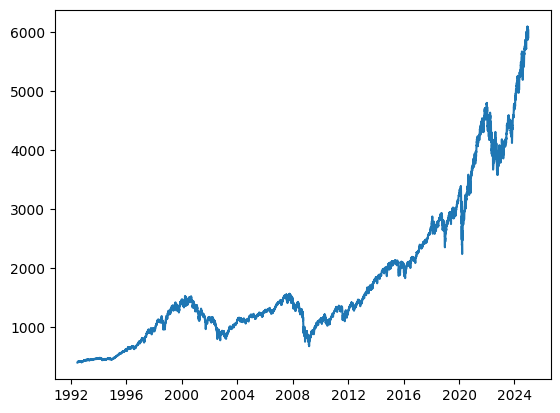

In [16]:
import yfinance as yf
import matplotlib.pyplot as plt
sp500 = yf.download('^GSPC', start='1992-06-18', end='2024-12-31')
prices = sp500['Close']
plt.plot(prices)

# Preprocess the data: calculate returns or normalize directly
log_returns = np.log(prices / prices.shift(1)).dropna()
normalized_data = (log_returns - log_returns.mean()) / log_returns.std()

# Convert to a numpy array for training
training_data = normalized_data.values

In [18]:
from qiskit import QuantumCircuit, transpile, assemble
from qiskit_aer import AerSimulator
from qiskit.circuit.library import RZGate, RXGate
import numpy as np


class QuantumGenerator:
    def __init__(self, num_qubits, layers=1):
        self.num_qubits = num_qubits
        self.layers = layers
        self.params = np.random.uniform(0, 2 * np.pi, size=(layers, 2 * num_qubits))
        self.backend = AerSimulator()

    def build_circuit(self, params):
        qc = QuantumCircuit(self.num_qubits)

        # Step 1: Create entanglement (GHZ state for simplicity)
        for qubit in range(self.num_qubits):
            qc.h(qubit)
        for qubit in range(self.num_qubits - 1):
            qc.cx(qubit, qubit + 1)

        # Step 2: Add parameterized unitaries
        for layer in range(self.layers):
            for qubit in range(self.num_qubits):
                qc.rz(params[layer, qubit], qubit)
                qc.rx(params[layer, qubit + self.num_qubits], qubit)

        return qc

    def sample(self, shots=1024):
        # Build and execute the circuit
        qc = self.build_circuit(self.params)
        qc.measure_all()
        compiled_circuit = transpile(qc, self.backend)
        result = self.backend.run(compiled_circuit, shots=shots).result()
        counts = result.get_counts()
        return counts

    def train(self, target_distribution, iterations=100, alpha=0.01):
        for iteration in range(iterations):
            gradients = self._compute_gradients(target_distribution)
            self.params -= alpha * gradients

    def _compute_gradients(self, target_distribution):
        # Simplified gradient calculation using finite differences
        gradients = np.zeros_like(self.params)
        perturb = np.pi / 10

        for layer in range(self.layers):
            for param_idx in range(2 * self.num_qubits):
                original_value = self.params[layer, param_idx]

                self.params[layer, param_idx] = original_value + perturb
                plus_counts = self.sample()

                self.params[layer, param_idx] = original_value - perturb
                minus_counts = self.sample()

                self.params[layer, param_idx] = original_value

                gradients[layer, param_idx] = self._kl_divergence(plus_counts, target_distribution) - \
                                             self._kl_divergence(minus_counts, target_distribution)
        return gradients

    @staticmethod
    def _kl_divergence(distribution_p, distribution_q):
        p_values = np.array([distribution_p.get(k, 0) for k in distribution_q.keys()], dtype=np.float64)
        q_values = np.array(list(distribution_q.values()), dtype=np.float64)

        # Normalize distributions
        p_values = p_values / p_values.sum()
        q_values = q_values / q_values.sum()

        return np.sum(p_values * np.log(p_values / (q_values + 1e-10) + 1e-10))

# Example usage
num_qubits = 4
generator = QuantumGenerator(num_qubits=num_qubits)

# Define a simple target distribution (for demonstration purposes)
target_distribution = {'0000': 0.25, '1111': 0.25, '1010': 0.25, '0101': 0.25}
print(type(target_distribution))
# target_distribution = training_data

# Train the generator
generator.train(target_distribution, iterations=5)

# Generate samples
sample = generator.sample()

print("Generated samples:", sample)


<class 'dict'>
Generated samples: {'1001': 5, '1100': 3, '0100': 9, '0101': 3, '1000': 8, '1110': 28, '1010': 102, '1011': 84, '0011': 234, '0001': 21, '0110': 72, '0000': 20, '0010': 345, '0111': 65, '1111': 25}
